In [17]:
dataset_dir =r"C:/Users/User/Desktop/rakin2/insulator-segmentation/"
csv_file = '/home/rakin/Desktop/segment/artifacts/train_data.csv'  # Update with the actual path
import os 

In [18]:
imag_dir = os.path.join(dataset_dir,'images/glass')
mask_dir = os.path.join(dataset_dir,'mask/glass')
print(imag_dir, mask_dir)
print(len(os.listdir(imag_dir)))
print(len(os.listdir(mask_dir)))
assert len(os.listdir(mask_dir)) == len(os.listdir(imag_dir))



C:/Users/User/Desktop/rakin2/insulator-segmentation/images/glass C:/Users/User/Desktop/rakin2/insulator-segmentation/mask/glass
13135
13135


In [19]:

images_dir_list = []
mask_dir_list = []
for i in os.listdir(imag_dir): 
    images_dir_list.append(os.path.join(imag_dir,i))
    mask_dir_list.append(os.path.join(mask_dir,i))
    


In [20]:
import pandas as pd 
from PIL.Image import open
from torchmetrics.segmentation import MeanIoU , GeneralizedDiceScore 
from torchmetrics.classification import BinaryAccuracy,BinaryJaccardIndex
from Seg.utils.common import read_yaml
from Seg.utils.logger import logger
from tqdm import tqdm
import matplotlib.pyplot as plt 
import torch
import albumentations as A
import numpy as np
import datetime as dt 
from sklearn.model_selection import train_test_split
import segmentation_models_pytorch as smp
from  Seg.components.models import  model_list , R2U_Net,AttU_Net
#config = read_yaml(r"Desktop/segment/config/config.yaml")
date_time = dt.datetime.now().strftime("%Y%m%d-%H%M%S")
logger.info(f"date_time: {date_time}")

# criterion = torch.nn.BCEWithLogitsLoss()
#criterion = torch.nn.CrossEntropyLoss()
criterion = smp.losses.DiceLoss(mode='binary')
# focal loss
#criterion = smp.losses.FocalLoss(mode='binary',gamma=1.0)
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
BinaryJaccardIndex_Score = BinaryJaccardIndex().to('cuda')

[2025-03-09 01:16:44,815: INFO: 3804955329: date_time: 20250309-011644]


In [21]:
Train_config = {
  "device" : "cuda",
  "batch_size" : 6,
  "epochs" : 20,
  "lr" : 0.001,
  "loss" : "dice_loss" #dice_loss
}

Model_config = {
    "model_name" : "unet",
    "backbone" : "resnet50", #resnet34
    "weights" : "imagenet",
    "in_channels" : 3 
}

Transform_config = {
    #train transform config 
   "image_size" : 512, 
   "shift_limit" : 0.2,
   "scale_limit" : 0.2,
   "rotate_limit" : 30,
   "ShiftScaleRotate_p" : 0.5, 
   "r_shift_limit" : 25,
   "g_shift_limit" : 25,
   "b_shift_limit" : 25,
   "RGB_Shift_p" : 0.5,
   "brightness_limit" : 0.3, 
   "contrast_limit" : 0.3,
   "RandomBrightnessContrast_p" : 0.5
}
Data_injection = {
    "seed" : 42, 
    "dataset_dir" : "Desktop/rakin2/segment/artifacts/dataset.csv",
    "train_csv_dir" : "Desktop/rakin2/segment/artifacts/train_data.csv",
    "test_csv_dir" : "Desktop/rakin2/segment/artifacts/test_data.csv",
    "val_csv_dir" : "Desktop/rakin2/segment/artifacts/val_data.csv"
}


In [22]:
train_config=Train_config
model_config=Model_config
transform_config=Transform_config
data_injecton_config =Data_injection
logger.info(f"train_config: {train_config}") 
logger.info(f"model_config: {model_config}")
logger.info(f"transform_config: {transform_config}")
logger.info(f"data_injecton_config: {data_injecton_config}")



[2025-03-09 01:16:44,844: INFO: 342151172: train_config: {'device': 'cuda', 'batch_size': 6, 'epochs': 20, 'lr': 0.001, 'loss': 'dice_loss'}]
[2025-03-09 01:16:44,845: INFO: 342151172: model_config: {'model_name': 'unet', 'backbone': 'resnet50', 'weights': 'imagenet', 'in_channels': 3}]
[2025-03-09 01:16:44,845: INFO: 342151172: transform_config: {'image_size': 512, 'shift_limit': 0.2, 'scale_limit': 0.2, 'rotate_limit': 30, 'ShiftScaleRotate_p': 0.5, 'r_shift_limit': 25, 'g_shift_limit': 25, 'b_shift_limit': 25, 'RGB_Shift_p': 0.5, 'brightness_limit': 0.3, 'contrast_limit': 0.3, 'RandomBrightnessContrast_p': 0.5}]
[2025-03-09 01:16:44,846: INFO: 342151172: data_injecton_config: {'seed': 42, 'dataset_dir': 'Desktop/rakin2/segment/artifacts/dataset.csv', 'train_csv_dir': 'Desktop/rakin2/segment/artifacts/train_data.csv', 'test_csv_dir': 'Desktop/rakin2/segment/artifacts/test_data.csv', 'val_csv_dir': 'Desktop/rakin2/segment/artifacts/val_data.csv'}]


(-0.5, 511.5, 511.5, -0.5)

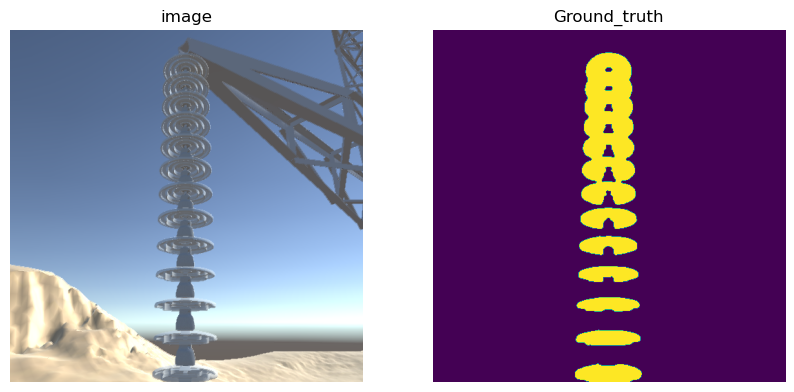

In [23]:


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,8))
ax1.imshow(open(images_dir_list[2]))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(open(mask_dir_list[2]))
ax2.set_title('Ground_truth')
ax2.axis('off')


In [24]:
x=pd.DataFrame({'imag_dir_list': images_dir_list , 'mask_dir_list':mask_dir_list})

In [25]:
x.to_csv('dataset.csv')

In [26]:

from PIL import Image
from torch.utils.data import Dataset



class SegmentDataset(Dataset):
    """
    DroneDataset class for loading the dataset with one-hot encoded masks.

    Args:
        img_path: Path to the images directory.
        mask_path: Path to the masks directory.
        X: List of image names.
        transform: Data augmentation transformations.

    Returns:
        image: Image tensor.
        mask: One-hot encoded mask tensor.
    """

    def __init__(self, csv_path , num_classes=2, transform=None):
        self.dataset = pd.read_csv(csv_path)
        self.img_path = self.dataset['imag_dir_list']
        self.mask_path = self.dataset['mask_dir_list']
        self.num_classes = num_classes  # Number of classes for one-hot encoding
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Load image and mask
        image = np.array(Image.open(self.img_path[idx]).convert("RGB"))
        mask = np.array(Image.open(self.mask_path[idx]).convert("L"))  # Grayscale mask

        # Apply Albumentations transformations (if any)
        if self.transform is not None:
            augmented = self.transform(image=image, mask=mask)
            image = augmented["image"]
            mask = augmented["mask"]

        # One-hot encode the mask
        mask_one_hot = np.zeros((mask.shape[0], mask.shape[1], self.num_classes), dtype=np.float32)
        
        # Create one-hot encoding using the unique values in the mask
        for i, unique_value in enumerate(np.unique(mask)):
            mask_one_hot[:, :, i][mask == unique_value] = 1
        
        # Normalize the image using Albumentations Normalize
        norm = A.Normalize(mean=(0 ,0, 0), std=(1, 1, 1))(image=image, mask=mask_one_hot)
        
        # Return image and one-hot encoded mask as tensors in [C, H, W] format
        return norm["image"].transpose(2, 0, 1), norm["mask"].transpose(2, 0, 1).astype("float32")



In [27]:

class DataInjection():
    def __init__(self , Dataset_dir) -> None:
        self.dataset = pd.read_csv(Dataset_dir)
        #self.injection_config = config["Data_injection"]
        

    def inject(self):
        logger.info('data injection started')
        if 'Unnamed: 0' in self.dataset.columns:
            dataset_cleaned = self.dataset.drop(columns=['Unnamed: 0'])
        else:
            dataset_cleaned = self.dataset

        logger.info('train data spliting ')
        train_data, temp_data = train_test_split(dataset_cleaned, test_size=0.2, random_state=42)
        logger.info('val test spliting ')
        val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

        logger.info('csv saving started')   
        train_data.to_csv('train_data.csv', index=False)
        logger.info('train csv done ')
        val_data.to_csv('val_data.csv', index=False)
        logger.info('val csv done ')
        test_data.to_csv('test_data.csv', index=False)
        logger.info('test csv done')


In [28]:
dInj = DataInjection("C:/Users/User/Desktop/rakin2/segment/notebook/dataset.csv")
dInj.inject()

[2025-03-09 01:16:45,197: INFO: 3993860970: data injection started]
[2025-03-09 01:16:45,198: INFO: 3993860970: train data spliting ]
[2025-03-09 01:16:45,200: INFO: 3993860970: val test spliting ]
[2025-03-09 01:16:45,201: INFO: 3993860970: csv saving started]
[2025-03-09 01:16:45,232: INFO: 3993860970: train csv done ]
[2025-03-09 01:16:45,240: INFO: 3993860970: val csv done ]
[2025-03-09 01:16:45,244: INFO: 3993860970: test csv done]


In [29]:



def model_selection(model_name: str, model_encoder: str, weight: str):
    """
    arg:
      model_name(str) name of the model
      model_encoder(str) : name of the encoder used


    return : model object with given encoder

    """

    model = smp.create_model(
        arch=model_name,  # name of the architecture, e.g. 'Unet'/ 'FPN' / etc. Case INsensitive!
        encoder_name=model_encoder,
        encoder_weights=weight,
        in_channels=3,
        classes=2,
    )

    return model



transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
    ])
   

In [30]:
model = model_selection(Model_config['model_name'], Model_config['backbone'],Model_config['weights'])
model=model.to('cuda')
#model = AttU_Net(3,2).to('cuda')


In [31]:
Train_DL_config = {
    "train_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/train_data.csv",
    "batch_size": 6,
    "num_workers": 4,
    "shuffle": True
}

Val_DL_config = {
    "val_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/val_data.csv",
    "batch_size": 2,
    "num_workers": 4,
    "shuffle": False,
    "transform": True,
    "random_blur": False
}

Test_DL_config = {
    # setting to val as test dir is corrupted in local drive
   "test_dirs": "C:/Users/User/Desktop/rakin2/segment/artifacts/test_data.csv",
   "batch_size": 2,
   "num_workers": 4,
   "shuffle": False,
   "transform": True
}

In [32]:

train_data = SegmentDataset(Train_DL_config['train_dirs'],2,transform=transform )
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=Train_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])
test_data = SegmentDataset(Test_DL_config['test_dirs'],2,transform=transform )
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=Test_DL_config['batch_size'], shuffle=Test_DL_config['shuffle'])
val_data = SegmentDataset(Val_DL_config['val_dirs'],2,transform=transform )
val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=Val_DL_config['batch_size'], shuffle=Train_DL_config['shuffle'])

In [33]:
optimizer = torch.optim.Adam(model.parameters(), lr=train_config['lr'])

mean_iou_score_for_training = []
dice_score_for_training =[]
accuracy_for_training = []
train_loss=[]
binary_jaccard_index_for_training = []
dice_coefficient_for_training = []

mean_iou_score = []
dice_score =[]
accuracy = []
val_loss =[]
binary_jaccard_index = []
dice_coefficient = []

for epoch in range(train_config['epochs']):    
    model.train()
    total_losses = 0
    pbar = tqdm(enumerate(train_dataloader), total = len(train_dataloader),colour='green')
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        optimizer.zero_grad()
        y_hat = model(x)
        loss = criterion(y_hat,y)
    
        loss.backward()
        optimizer.step()
        total_losses += loss.item()
        jeq_indx_for_training = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou_for_training = IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values_for_training = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc_for_training = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_iou_score_for_training.append(mean_miou_for_training)
        dice_score_for_training.append(dice_score_values_for_training)
        binary_jaccard_index_for_training.append(jeq_indx_for_training)
        dice_coefficient_for_training.append((2*jeq_indx_for_training*1/(1+jeq_indx_for_training)))
        accuracy_for_training.append(acc_for_training)
        train_loss.append(total_losses/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"train_loss": total_losses / (i + 1) , 
                                  "train_Miou_score": sum(mean_iou_score_for_training)/len(mean_iou_score_for_training) ,
                                    "train_dice_score" : sum(dice_score_for_training)/len(dice_score_for_training),
                                   "train_acc": sum(accuracy_for_training)/len(accuracy_for_training),
                                   "train_binary_jaccard_index": sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training),
                                    "train_dice_coefficient": sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)} )

    # mlflow metrics
    #mlflow.log_metric("train_loss", sum(train_loss) / len(train_loss), step=epoch)
    logger.info(f"Epoch: {epoch} | Training_Loss: {total_losses / len(train_dataloader)}")
    # mlflow metrics
    logger.info(f"train_loss {sum(train_loss) / len(train_loss) }")
    logger.info(f"train_Miou_score {sum(mean_iou_score_for_training)/len(mean_iou_score_for_training)}" )
    logger.info(f"train_dice_score {sum(dice_score_for_training)/len(dice_score_for_training)}" )
    logger.info(f"train_acc {sum(accuracy_for_training)/len(accuracy_for_training)}" )
    logger.info(f"train_binary_jaccard_index: {sum(binary_jaccard_index_for_training)/len(binary_jaccard_index_for_training)}")
    logger.info(f"train_dice_coefficient: {sum(dice_coefficient_for_training)/len(dice_coefficient_for_training)}")

    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()
    
    total_loss = 0.0
    model.eval()
 
    pbar = tqdm(enumerate(val_dataloader), total=len(val_dataloader),colour="blue")
    
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')
        y_hat = model(x)
        loss = criterion(y_hat, y)
    
        total_loss += loss.item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        binary_jaccard_index.append(jeq_indx)
        dice_score.append(dice_score_values)
        accuracy.append(acc)
        val_loss.append(total_loss/ (i + 1))
        pbar.set_postfix({"epoch": epoch,"eval_loss": total_loss / (i + 1) , 
                                  "eval_Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                                    "eval_dice_score" : sum(dice_score)/len(dice_score),
                                   "eval_acc": sum(accuracy)/len(accuracy),
                                   "eval_binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                                     "eval_dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)} )
        
        #save model  if val loss is minimum
        
        

    #torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin/segment/artifacts/model_ckpt/unet_{date_time}.pth')
    
    logger.info(f"Epoch: {epoch} | Loss: {total_loss / len(val_dataloader)}")
    # mlflow metrics
    logger.info(f"eval_loss {sum(val_loss) / len(val_loss) }")
    logger.info(f"eval_Miou_score {sum(mean_iou_score)/len(mean_iou_score)}" )
    logger.info(f"eval_dice_score {sum(dice_score)/len(dice_score)}" )
    logger.info(f"eval_acc {sum(accuracy)/len(accuracy)}" )
    logger.info(f"eval_binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    logger.info(f"eval_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    
    IoUScore.reset()
    DiceScore.reset()
    BinaryAccuracy_Score.reset()
    BinaryJaccardIndex_Score.reset()
    pbar.close()

100%|██████████| 1752/1752 [08:42<00:00,  3.35it/s, epoch=0, train_loss=0.0144, train_Miou_score=0.527, train_dice_score=0.614, train_acc=0.991, train_binary_jaccard_index=0.863, train_dice_coefficient=0.923]

[2025-03-09 01:25:28,849: INFO: 2273413975: Epoch: 0 | Training_Loss: 0.014379380126249845]
[2025-03-09 01:25:28,850: INFO: 2273413975: train_loss 0.03880611088240643]
[2025-03-09 01:25:28,851: INFO: 2273413975: train_Miou_score 0.527254299303202]
[2025-03-09 01:25:28,852: INFO: 2273413975: train_dice_score 0.6143518851742522]
[2025-03-09 01:25:28,853: INFO: 2273413975: train_acc 0.9908300895737187]
[2025-03-09 01:25:28,854: INFO: 2273413975: train_binary_jaccard_index: 0.8626348573425316]
[2025-03-09 01:25:28,854: INFO: 2273413975: train_dice_coefficient: 0.9226404913635964]



100%|██████████| 657/657 [01:08<00:00,  9.63it/s, epoch=0, eval_loss=0.00455, eval_Miou_score=0.562, eval_dice_score=0.733, eval_acc=0.996, eval_binary_jaccard_index=0.921, eval_dice_coefficient=0.958]

[2025-03-09 01:26:37,072: INFO: 2273413975: Epoch: 0 | Loss: 0.004549377675833042]
[2025-03-09 01:26:37,073: INFO: 2273413975: eval_loss 0.0048204346145028195]
[2025-03-09 01:26:37,074: INFO: 2273413975: eval_Miou_score 0.5621569290689138]
[2025-03-09 01:26:37,074: INFO: 2273413975: eval_dice_score 0.7329032849775602]
[2025-03-09 01:26:37,075: INFO: 2273413975: eval_acc 0.995596271671661]
[2025-03-09 01:26:37,075: INFO: 2273413975: eval_binary_jaccard_index: 0.9205401729412456]


[2025-03-09 01:26:37,075: INFO: 2273413975: eval_dice_coefficient: 0.9581005572283756]


100%|██████████| 1752/1752 [06:17<00:00,  4.64it/s, epoch=1, train_loss=0.0052, train_Miou_score=0.543, train_dice_score=0.652, train_acc=0.993, train_binary_jaccard_index=0.889, train_dice_coefficient=0.939] 

[2025-03-09 01:32:54,297: INFO: 2273413975: Epoch: 1 | Training_Loss: 0.0051959147464194794]
[2025-03-09 01:32:54,297: INFO: 2273413975: train_loss 0.021632823372350476]
[2025-03-09 01:32:54,298: INFO: 2273413975: train_Miou_score 0.5434363358951765]
[2025-03-09 01:32:54,299: INFO: 2273413975: train_dice_score 0.6520036320046833]
[2025-03-09 01:32:54,299: INFO: 2273413975: train_acc 0.9928705483232731]
[2025-03-09 01:32:54,300: INFO: 2273413975: train_binary_jaccard_index: 0.8893304463714089]
[2025-03-09 01:32:54,300: INFO: 2273413975: train_dice_coefficient: 0.9390574946286048]



100%|██████████| 657/657 [00:41<00:00, 15.70it/s, epoch=1, eval_loss=0.0136, eval_Miou_score=0.52, eval_dice_score=0.66, eval_acc=0.991, eval_binary_jaccard_index=0.843, eval_dice_coefficient=0.907]  

[2025-03-09 01:33:36,160: INFO: 2273413975: Epoch: 1 | Loss: 0.013608919612530341]
[2025-03-09 01:33:36,160: INFO: 2273413975: eval_loss 0.008943782110719462]
[2025-03-09 01:33:36,161: INFO: 2273413975: eval_Miou_score 0.5204697104292827]
[2025-03-09 01:33:36,162: INFO: 2273413975: eval_dice_score 0.6595660164524182]
[2025-03-09 01:33:36,162: INFO: 2273413975: eval_acc 0.9910254732477429]
[2025-03-09 01:33:36,163: INFO: 2273413975: eval_binary_jaccard_index: 0.8433457298241159]
[2025-03-09 01:33:36,163: INFO: 2273413975: eval_dice_coefficient: 0.9073638357914972]



100%|██████████| 1752/1752 [06:17<00:00,  4.64it/s, epoch=2, train_loss=0.00401, train_Miou_score=0.552, train_dice_score=0.674, train_acc=0.994, train_binary_jaccard_index=0.904, train_dice_coefficient=0.948]

[2025-03-09 01:39:53,609: INFO: 2273413975: Epoch: 2 | Training_Loss: 0.004006743941405048]
[2025-03-09 01:39:53,610: INFO: 2273413975: train_loss 0.015796412700347227]
[2025-03-09 01:39:53,611: INFO: 2273413975: train_Miou_score 0.5524442034023651]
[2025-03-09 01:39:53,612: INFO: 2273413975: train_dice_score 0.6738777700988817]
[2025-03-09 01:39:53,613: INFO: 2273413975: train_acc 0.9939255081854274]
[2025-03-09 01:39:53,613: INFO: 2273413975: train_binary_jaccard_index: 0.9036504964612119]
[2025-03-09 01:39:53,614: INFO: 2273413975: train_dice_coefficient: 0.9476045895921321]



100%|██████████| 657/657 [00:43<00:00, 15.03it/s, epoch=2, eval_loss=0.00359, eval_Miou_score=0.54, eval_dice_score=0.687, eval_acc=0.993, eval_binary_jaccard_index=0.873, eval_dice_coefficient=0.927] 

[2025-03-09 01:40:37,338: INFO: 2273413975: Epoch: 2 | Loss: 0.003589685739810427]
[2025-03-09 01:40:37,339: INFO: 2273413975: eval_loss 0.007146593558465225]
[2025-03-09 01:40:37,339: INFO: 2273413975: eval_Miou_score 0.5396952904998984]
[2025-03-09 01:40:37,340: INFO: 2273413975: eval_dice_score 0.6868224326154488]
[2025-03-09 01:40:37,340: INFO: 2273413975: eval_acc 0.9928303200360302]
[2025-03-09 01:40:37,341: INFO: 2273413975: eval_binary_jaccard_index: 0.8733748461595651]
[2025-03-09 01:40:37,341: INFO: 2273413975: eval_dice_coefficient: 0.9266380056346164]



100%|██████████| 1752/1752 [06:18<00:00,  4.63it/s, epoch=3, train_loss=0.00388, train_Miou_score=0.558, train_dice_score=0.687, train_acc=0.994, train_binary_jaccard_index=0.911, train_dice_coefficient=0.952]

[2025-03-09 01:46:55,687: INFO: 2273413975: Epoch: 3 | Training_Loss: 0.0038847003693449986]
[2025-03-09 01:46:55,688: INFO: 2273413975: train_loss 0.012904245304601781]
[2025-03-09 01:46:55,690: INFO: 2273413975: train_Miou_score 0.5575816453568484]
[2025-03-09 01:46:55,691: INFO: 2273413975: train_dice_score 0.6866076865630037]
[2025-03-09 01:46:55,692: INFO: 2273413975: train_acc 0.9944809775493325]
[2025-03-09 01:46:55,693: INFO: 2273413975: train_binary_jaccard_index: 0.9114244636360845]
[2025-03-09 01:46:55,694: INFO: 2273413975: train_dice_coefficient: 0.9521857311871431]



100%|██████████| 657/657 [00:43<00:00, 15.07it/s, epoch=3, eval_loss=0.00358, eval_Miou_score=0.55, eval_dice_score=0.696, eval_acc=0.994, eval_binary_jaccard_index=0.889, eval_dice_coefficient=0.936] 

[2025-03-09 01:47:39,305: INFO: 2273413975: Epoch: 3 | Loss: 0.0035784475879582097]
[2025-03-09 01:47:39,306: INFO: 2273413975: eval_loss 0.006253152977440233]
[2025-03-09 01:47:39,307: INFO: 2273413975: eval_Miou_score 0.54970405316278]
[2025-03-09 01:47:39,307: INFO: 2273413975: eval_dice_score 0.695609460306273]
[2025-03-09 01:47:39,307: INFO: 2273413975: eval_acc 0.993733806697201]
[2025-03-09 01:47:39,308: INFO: 2273413975: eval_binary_jaccard_index: 0.8886491232431144]
[2025-03-09 01:47:39,308: INFO: 2273413975: eval_dice_coefficient: 0.9364141853717319]



100%|██████████| 1752/1752 [06:16<00:00,  4.65it/s, epoch=4, train_loss=0.00352, train_Miou_score=0.561, train_dice_score=0.697, train_acc=0.995, train_binary_jaccard_index=0.917, train_dice_coefficient=0.956]

[2025-03-09 01:53:56,157: INFO: 2273413975: Epoch: 4 | Training_Loss: 0.0035166516559853402]
[2025-03-09 01:53:56,158: INFO: 2273413975: train_loss 0.010967708790682184]
[2025-03-09 01:53:56,159: INFO: 2273413975: train_Miou_score 0.5613451429706526]
[2025-03-09 01:53:56,159: INFO: 2273413975: train_dice_score 0.6974574210083954]
[2025-03-09 01:53:56,160: INFO: 2273413975: train_acc 0.9948861401851319]
[2025-03-09 01:53:56,161: INFO: 2273413975: train_binary_jaccard_index: 0.9172382202016436]
[2025-03-09 01:53:56,161: INFO: 2273413975: train_dice_coefficient: 0.9555551693399598]



100%|██████████| 657/657 [00:42<00:00, 15.40it/s, epoch=4, eval_loss=0.00407, eval_Miou_score=0.554, eval_dice_score=0.704, eval_acc=0.994, eval_binary_jaccard_index=0.896, eval_dice_coefficient=0.941]

[2025-03-09 01:54:38,816: INFO: 2273413975: Epoch: 4 | Loss: 0.0040661278017761135]
[2025-03-09 01:54:38,817: INFO: 2273413975: eval_loss 0.0057889618171590405]
[2025-03-09 01:54:38,817: INFO: 2273413975: eval_Miou_score 0.5536411692902922]
[2025-03-09 01:54:38,818: INFO: 2273413975: eval_dice_score 0.7041682374696254]
[2025-03-09 01:54:38,819: INFO: 2273413975: eval_acc 0.9941798589000963]
[2025-03-09 01:54:38,819: INFO: 2273413975: eval_binary_jaccard_index: 0.8961813073202718]
[2025-03-09 01:54:38,820: INFO: 2273413975: eval_dice_coefficient: 0.9413097367960113]



100%|██████████| 1752/1752 [06:17<00:00,  4.64it/s, epoch=5, train_loss=0.00361, train_Miou_score=0.564, train_dice_score=0.704, train_acc=0.995, train_binary_jaccard_index=0.921, train_dice_coefficient=0.958]

[2025-03-09 02:00:56,485: INFO: 2273413975: Epoch: 5 | Training_Loss: 0.0036064264913127845]
[2025-03-09 02:00:56,486: INFO: 2273413975: train_loss 0.00974403044362875]
[2025-03-09 02:00:56,487: INFO: 2273413975: train_Miou_score 0.5639189107030279]
[2025-03-09 02:00:56,488: INFO: 2273413975: train_dice_score 0.7042771158346558]
[2025-03-09 02:00:56,488: INFO: 2273413975: train_acc 0.9951401668256277]
[2025-03-09 02:00:56,490: INFO: 2273413975: train_binary_jaccard_index: 0.9208435830114412]
[2025-03-09 02:00:56,490: INFO: 2273413975: train_dice_coefficient: 0.957654892805552]



100%|██████████| 657/657 [00:42<00:00, 15.40it/s, epoch=5, eval_loss=0.00338, eval_Miou_score=0.558, eval_dice_score=0.714, eval_acc=0.995, eval_binary_jaccard_index=0.903, eval_dice_coefficient=0.946]

[2025-03-09 02:01:39,147: INFO: 2273413975: Epoch: 5 | Loss: 0.0033788404326823567]
[2025-03-09 02:01:39,148: INFO: 2273413975: eval_loss 0.005392689251897819]
[2025-03-09 02:01:39,149: INFO: 2273413975: eval_Miou_score 0.5582324096574842]
[2025-03-09 02:01:39,149: INFO: 2273413975: eval_dice_score 0.7140284937970389]
[2025-03-09 02:01:39,150: INFO: 2273413975: eval_acc 0.9945885945189005]
[2025-03-09 02:01:39,151: INFO: 2273413975: eval_binary_jaccard_index: 0.9033718060065138]
[2025-03-09 02:01:39,152: INFO: 2273413975: eval_dice_coefficient: 0.9457350983173508]



100%|██████████| 1752/1752 [06:16<00:00,  4.65it/s, epoch=6, train_loss=0.00292, train_Miou_score=0.567, train_dice_score=0.712, train_acc=0.995, train_binary_jaccard_index=0.925, train_dice_coefficient=0.96] 

[2025-03-09 02:07:56,065: INFO: 2273413975: Epoch: 6 | Training_Loss: 0.0029168846468402916]
[2025-03-09 02:07:56,066: INFO: 2273413975: train_loss 0.008769864240006984]
[2025-03-09 02:07:56,067: INFO: 2273413975: train_Miou_score 0.5666186189295971]
[2025-03-09 02:07:56,068: INFO: 2273413975: train_dice_score 0.7119199025173734]
[2025-03-09 02:07:56,069: INFO: 2273413975: train_acc 0.9954191234402616]
[2025-03-09 02:07:56,069: INFO: 2273413975: train_binary_jaccard_index: 0.9249263772326634]
[2025-03-09 02:07:56,070: INFO: 2273413975: train_dice_coefficient: 0.9599824377677741]



100%|██████████| 657/657 [00:43<00:00, 15.12it/s, epoch=6, eval_loss=0.003, eval_Miou_score=0.562, eval_dice_score=0.722, eval_acc=0.995, eval_binary_jaccard_index=0.909, eval_dice_coefficient=0.949]  

[2025-03-09 02:08:39,529: INFO: 2273413975: Epoch: 6 | Loss: 0.0030019947382957423]
[2025-03-09 02:08:39,530: INFO: 2273413975: eval_loss 0.005053661957960921]
[2025-03-09 02:08:39,531: INFO: 2273413975: eval_Miou_score 0.5621742499191544]
[2025-03-09 02:08:39,532: INFO: 2273413975: eval_dice_score 0.7221235564032419]
[2025-03-09 02:08:39,532: INFO: 2273413975: eval_acc 0.9949340559031865]
[2025-03-09 02:08:39,533: INFO: 2273413975: eval_binary_jaccard_index: 0.9092499367580074]
[2025-03-09 02:08:39,534: INFO: 2273413975: eval_dice_coefficient: 0.949358519176381]



100%|██████████| 1752/1752 [06:17<00:00,  4.64it/s, epoch=7, train_loss=0.00332, train_Miou_score=0.568, train_dice_score=0.716, train_acc=0.996, train_binary_jaccard_index=0.927, train_dice_coefficient=0.961]

[2025-03-09 02:14:57,515: INFO: 2273413975: Epoch: 7 | Training_Loss: 0.0033207328896544294]
[2025-03-09 02:14:57,517: INFO: 2273413975: train_loss 0.008092779909065238]
[2025-03-09 02:14:57,517: INFO: 2273413975: train_Miou_score 0.5682391103651571]
[2025-03-09 02:14:57,519: INFO: 2273413975: train_dice_score 0.716365791930866]
[2025-03-09 02:14:57,521: INFO: 2273413975: train_acc 0.9955776863727192]
[2025-03-09 02:14:57,522: INFO: 2273413975: train_binary_jaccard_index: 0.9272005345702138]
[2025-03-09 02:14:57,523: INFO: 2273413975: train_dice_coefficient: 0.9612939369887615]



100%|██████████| 657/657 [00:43<00:00, 15.25it/s, epoch=7, eval_loss=0.0032, eval_Miou_score=0.565, eval_dice_score=0.727, eval_acc=0.995, eval_binary_jaccard_index=0.913, eval_dice_coefficient=0.952] 

[2025-03-09 02:15:40,616: INFO: 2273413975: Epoch: 7 | Loss: 0.0032012279356632783]
[2025-03-09 02:15:40,617: INFO: 2273413975: eval_loss 0.004844562798295913]
[2025-03-09 02:15:40,618: INFO: 2273413975: eval_Miou_score 0.5647171790749855]
[2025-03-09 02:15:40,619: INFO: 2273413975: eval_dice_score 0.7274910837225474]
[2025-03-09 02:15:40,620: INFO: 2273413975: eval_acc 0.9951683977786083]
[2025-03-09 02:15:40,621: INFO: 2273413975: eval_binary_jaccard_index: 0.9132903151418248]
[2025-03-09 02:15:40,621: INFO: 2273413975: eval_dice_coefficient: 0.9518709314064222]



100%|██████████| 1752/1752 [06:19<00:00,  4.62it/s, epoch=8, train_loss=0.00303, train_Miou_score=0.57, train_dice_score=0.721, train_acc=0.996, train_binary_jaccard_index=0.929, train_dice_coefficient=0.963] 

[2025-03-09 02:21:59,644: INFO: 2273413975: Epoch: 8 | Training_Loss: 0.003029461456760424]
[2025-03-09 02:21:59,645: INFO: 2273413975: train_loss 0.007545167700333875]
[2025-03-09 02:21:59,646: INFO: 2273413975: train_Miou_score 0.5697143650105774]
[2025-03-09 02:21:59,647: INFO: 2273413975: train_dice_score 0.7208101210219361]
[2025-03-09 02:21:59,647: INFO: 2273413975: train_acc 0.9957332585454894]
[2025-03-09 02:21:59,647: INFO: 2273413975: train_binary_jaccard_index: 0.9294879384270814]
[2025-03-09 02:21:59,649: INFO: 2273413975: train_dice_coefficient: 0.9626016092504454]



100%|██████████| 657/657 [00:43<00:00, 15.00it/s, epoch=8, eval_loss=0.00266, eval_Miou_score=0.567, eval_dice_score=0.732, eval_acc=0.995, eval_binary_jaccard_index=0.917, eval_dice_coefficient=0.954]

[2025-03-09 02:22:43,464: INFO: 2273413975: Epoch: 8 | Loss: 0.002660283214969722]
[2025-03-09 02:22:43,465: INFO: 2273413975: eval_loss 0.004590290734453731]


[2025-03-09 02:22:43,466: INFO: 2273413975: eval_Miou_score 0.5673863101361892]
[2025-03-09 02:22:43,467: INFO: 2273413975: eval_dice_score 0.7324508534432208]
[2025-03-09 02:22:43,468: INFO: 2273413975: eval_acc 0.9954103769514941]
[2025-03-09 02:22:43,468: INFO: 2273413975: eval_binary_jaccard_index: 0.9173019953726028]
[2025-03-09 02:22:43,469: INFO: 2273413975: eval_dice_coefficient: 0.9543128543984786]


100%|██████████| 1752/1752 [06:20<00:00,  4.60it/s, epoch=9, train_loss=0.00296, train_Miou_score=0.571, train_dice_score=0.725, train_acc=0.996, train_binary_jaccard_index=0.931, train_dice_coefficient=0.964]

[2025-03-09 02:29:04,180: INFO: 2273413975: Epoch: 9 | Training_Loss: 0.002955141609117865]
[2025-03-09 02:29:04,181: INFO: 2273413975: train_loss 0.0070565042734605605]
[2025-03-09 02:29:04,182: INFO: 2273413975: train_Miou_score 0.5711340481377117]
[2025-03-09 02:29:04,183: INFO: 2273413975: train_dice_score 0.7248263705396369]
[2025-03-09 02:29:04,183: INFO: 2273413975: train_acc 0.9958649717373391]
[2025-03-09 02:29:04,185: INFO: 2273413975: train_binary_jaccard_index: 0.9314650219886407]
[2025-03-09 02:29:04,185: INFO: 2273413975: train_dice_coefficient: 0.9637198613258411]



100%|██████████| 657/657 [00:44<00:00, 14.72it/s, epoch=9, eval_loss=0.00285, eval_Miou_score=0.569, eval_dice_score=0.735, eval_acc=0.996, eval_binary_jaccard_index=0.92, eval_dice_coefficient=0.956] 

[2025-03-09 02:29:48,830: INFO: 2273413975: Epoch: 9 | Loss: 0.002849238738984641]
[2025-03-09 02:29:48,831: INFO: 2273413975: eval_loss 0.004424531997046577]
[2025-03-09 02:29:48,831: INFO: 2273413975: eval_Miou_score 0.5691803943496225]
[2025-03-09 02:29:48,832: INFO: 2273413975: eval_dice_score 0.7354967365812516]
[2025-03-09 02:29:48,832: INFO: 2273413975: eval_acc 0.9955848418051431]
[2025-03-09 02:29:48,833: INFO: 2273413975: eval_binary_jaccard_index: 0.9202254568559757]
[2025-03-09 02:29:48,834: INFO: 2273413975: eval_dice_coefficient: 0.9561148016007526]



100%|██████████| 1752/1752 [06:18<00:00,  4.62it/s, epoch=10, train_loss=0.00285, train_Miou_score=0.572, train_dice_score=0.728, train_acc=0.996, train_binary_jaccard_index=0.933, train_dice_coefficient=0.965]

[2025-03-09 02:36:07,838: INFO: 2273413975: Epoch: 10 | Training_Loss: 0.0028515595211285978]
[2025-03-09 02:36:07,839: INFO: 2273413975: train_loss 0.0066667769810345775]
[2025-03-09 02:36:07,840: INFO: 2273413975: train_Miou_score 0.5722515974313658]
[2025-03-09 02:36:07,841: INFO: 2273413975: train_dice_score 0.7284746959787318]
[2025-03-09 02:36:07,842: INFO: 2273413975: train_acc 0.9959820647669462]
[2025-03-09 02:36:07,843: INFO: 2273413975: train_binary_jaccard_index: 0.93324527580673]
[2025-03-09 02:36:07,844: INFO: 2273413975: train_dice_coefficient: 0.9647266674383147]



100%|██████████| 657/657 [00:43<00:00, 15.00it/s, epoch=10, eval_loss=0.00263, eval_Miou_score=0.571, eval_dice_score=0.74, eval_acc=0.996, eval_binary_jaccard_index=0.923, eval_dice_coefficient=0.958] 

[2025-03-09 02:36:51,654: INFO: 2273413975: Epoch: 10 | Loss: 0.002625172359576871]
[2025-03-09 02:36:51,655: INFO: 2273413975: eval_loss 0.004255881101553648]
[2025-03-09 02:36:51,656: INFO: 2273413975: eval_Miou_score 0.5709034834148331]
[2025-03-09 02:36:51,657: INFO: 2273413975: eval_dice_score 0.73952811768904]
[2025-03-09 02:36:51,657: INFO: 2273413975: eval_acc 0.9957479738473265]
[2025-03-09 02:36:51,658: INFO: 2273413975: eval_binary_jaccard_index: 0.9228618461981476]
[2025-03-09 02:36:51,659: INFO: 2273413975: eval_dice_coefficient: 0.9577158987471757]



100%|██████████| 1752/1752 [06:18<00:00,  4.63it/s, epoch=11, train_loss=0.00279, train_Miou_score=0.573, train_dice_score=0.732, train_acc=0.996, train_binary_jaccard_index=0.935, train_dice_coefficient=0.966]

[2025-03-09 02:43:10,371: INFO: 2273413975: Epoch: 11 | Training_Loss: 0.002788346856152086]
[2025-03-09 02:43:10,372: INFO: 2273413975: train_loss 0.006334033431157937]
[2025-03-09 02:43:10,373: INFO: 2273413975: train_Miou_score 0.5733191286680774]
[2025-03-09 02:43:10,374: INFO: 2273413975: train_dice_score 0.7316042691991201]
[2025-03-09 02:43:10,375: INFO: 2273413975: train_acc 0.9960848760239701]
[2025-03-09 02:43:10,376: INFO: 2273413975: train_binary_jaccard_index: 0.934804728057638]
[2025-03-09 02:43:10,377: INFO: 2273413975: train_dice_coefficient: 0.965606883696242]



100%|██████████| 657/657 [00:45<00:00, 14.50it/s, epoch=11, eval_loss=0.00271, eval_Miou_score=0.572, eval_dice_score=0.743, eval_acc=0.996, eval_binary_jaccard_index=0.925, eval_dice_coefficient=0.959]

[2025-03-09 02:43:55,688: INFO: 2273413975: Epoch: 11 | Loss: 0.0027115275144939917]
[2025-03-09 02:43:55,688: INFO: 2273413975: eval_loss 0.004133703187056669]
[2025-03-09 02:43:55,689: INFO: 2273413975: eval_Miou_score 0.57213710626953]
[2025-03-09 02:43:55,690: INFO: 2273413975: eval_dice_score 0.7428626758259079]
[2025-03-09 02:43:55,690: INFO: 2273413975: eval_acc 0.9958767218374468]
[2025-03-09 02:43:55,691: INFO: 2273413975: eval_binary_jaccard_index: 0.9249994745756817]
[2025-03-09 02:43:55,692: INFO: 2273413975: eval_dice_coefficient: 0.9590083798469523]



100%|██████████| 1752/1752 [06:17<00:00,  4.64it/s, epoch=12, train_loss=0.00265, train_Miou_score=0.574, train_dice_score=0.735, train_acc=0.996, train_binary_jaccard_index=0.936, train_dice_coefficient=0.966]

[2025-03-09 02:50:13,322: INFO: 2273413975: Epoch: 12 | Training_Loss: 0.0026474790349942908]
[2025-03-09 02:50:13,323: INFO: 2273413975: train_loss 0.006044072509520228]
[2025-03-09 02:50:13,324: INFO: 2273413975: train_Miou_score 0.574383229321156]
[2025-03-09 02:50:13,325: INFO: 2273413975: train_dice_score 0.7348092906617026]
[2025-03-09 02:50:13,326: INFO: 2273413975: train_acc 0.9961827080297729]
[2025-03-09 02:50:13,327: INFO: 2273413975: train_binary_jaccard_index: 0.9362913927067925]
[2025-03-09 02:50:13,327: INFO: 2273413975: train_dice_coefficient: 0.9664388332472199]



100%|██████████| 657/657 [00:39<00:00, 16.55it/s, epoch=12, eval_loss=0.00261, eval_Miou_score=0.573, eval_dice_score=0.746, eval_acc=0.996, eval_binary_jaccard_index=0.927, eval_dice_coefficient=0.96] 

[2025-03-09 02:50:53,040: INFO: 2273413975: Epoch: 12 | Loss: 0.002614908929647739]
[2025-03-09 02:50:53,041: INFO: 2273413975: eval_loss 0.004021463894425916]
[2025-03-09 02:50:53,042: INFO: 2273413975: eval_Miou_score 0.5730201543160826]
[2025-03-09 02:50:53,042: INFO: 2273413975: eval_dice_score 0.7459084464461937]
[2025-03-09 02:50:53,043: INFO: 2273413975: eval_acc 0.9959930942036511]
[2025-03-09 02:50:53,044: INFO: 2273413975: eval_binary_jaccard_index: 0.9268893095477237]
[2025-03-09 02:50:53,044: INFO: 2273413975: eval_dice_coefficient: 0.960153699709414]



100%|██████████| 1752/1752 [06:08<00:00,  4.75it/s, epoch=13, train_loss=0.00264, train_Miou_score=0.575, train_dice_score=0.738, train_acc=0.996, train_binary_jaccard_index=0.938, train_dice_coefficient=0.967]

[2025-03-09 02:57:01,963: INFO: 2273413975: Epoch: 13 | Training_Loss: 0.0026381304615164455]
[2025-03-09 02:57:01,964: INFO: 2273413975: train_loss 0.00580046997647712]
[2025-03-09 02:57:01,965: INFO: 2273413975: train_Miou_score 0.5752591361833611]
[2025-03-09 02:57:01,966: INFO: 2273413975: train_dice_score 0.7375333127424435]
[2025-03-09 02:57:01,967: INFO: 2273413975: train_acc 0.9962671956452022]
[2025-03-09 02:57:01,967: INFO: 2273413975: train_binary_jaccard_index: 0.9375778419030641]
[2025-03-09 02:57:01,968: INFO: 2273413975: train_dice_coefficient: 0.967159737526647]



100%|██████████| 657/657 [00:44<00:00, 14.91it/s, epoch=13, eval_loss=0.00263, eval_Miou_score=0.574, eval_dice_score=0.748, eval_acc=0.996, eval_binary_jaccard_index=0.929, eval_dice_coefficient=0.961]

[2025-03-09 02:57:46,021: INFO: 2273413975: Epoch: 13 | Loss: 0.0026279889285292257]
[2025-03-09 02:57:46,022: INFO: 2273413975: eval_loss 0.003920095968485749]
[2025-03-09 02:57:46,024: INFO: 2273413975: eval_Miou_score 0.574151679854836]
[2025-03-09 02:57:46,024: INFO: 2273413975: eval_dice_score 0.7482268115024423]
[2025-03-09 02:57:46,025: INFO: 2273413975: eval_acc 0.9960918380893243]
[2025-03-09 02:57:46,026: INFO: 2273413975: eval_binary_jaccard_index: 0.928523392700247]
[2025-03-09 02:57:46,027: INFO: 2273413975: eval_dice_coefficient: 0.9611470452906992]



100%|██████████| 1752/1752 [06:15<00:00,  4.67it/s, epoch=14, train_loss=0.00249, train_Miou_score=0.576, train_dice_score=0.74, train_acc=0.996, train_binary_jaccard_index=0.939, train_dice_coefficient=0.968] 

[2025-03-09 03:04:01,560: INFO: 2273413975: Epoch: 14 | Training_Loss: 0.0024900839209012243]
[2025-03-09 03:04:01,561: INFO: 2273413975: train_loss 0.0055810253130842225]
[2025-03-09 03:04:01,563: INFO: 2273413975: train_Miou_score 0.5761332479448736]
[2025-03-09 03:04:01,564: INFO: 2273413975: train_dice_score 0.740284686066817]
[2025-03-09 03:04:01,565: INFO: 2273413975: train_acc 0.9963502746534674]
[2025-03-09 03:04:01,565: INFO: 2273413975: train_binary_jaccard_index: 0.938848356481874]
[2025-03-09 03:04:01,567: INFO: 2273413975: train_dice_coefficient: 0.9678681734004929]



100%|██████████| 657/657 [00:40<00:00, 16.06it/s, epoch=14, eval_loss=0.00252, eval_Miou_score=0.575, eval_dice_score=0.75, eval_acc=0.996, eval_binary_jaccard_index=0.93, eval_dice_coefficient=0.962]  

[2025-03-09 03:04:42,480: INFO: 2273413975: Epoch: 14 | Loss: 0.0025152172127815143]
[2025-03-09 03:04:42,480: INFO: 2273413975: eval_loss 0.0038240287685496585]
[2025-03-09 03:04:42,481: INFO: 2273413975: eval_Miou_score 0.5751349205968648]
[2025-03-09 03:04:42,482: INFO: 2273413975: eval_dice_score 0.7502452762955294]
[2025-03-09 03:04:42,483: INFO: 2273413975: eval_acc 0.9961849065555164]
[2025-03-09 03:04:42,483: INFO: 2273413975: eval_binary_jaccard_index: 0.9300565216790475]
[2025-03-09 03:04:42,484: INFO: 2273413975: eval_dice_coefficient: 0.9620685373354303]



100%|██████████| 1752/1752 [06:16<00:00,  4.65it/s, epoch=15, train_loss=0.00277, train_Miou_score=0.577, train_dice_score=0.742, train_acc=0.996, train_binary_jaccard_index=0.94, train_dice_coefficient=0.968] 

[2025-03-09 03:10:58,915: INFO: 2273413975: Epoch: 15 | Training_Loss: 0.002769437690848085]
[2025-03-09 03:10:58,916: INFO: 2273413975: train_loss 0.005400755472044013]
[2025-03-09 03:10:58,917: INFO: 2273413975: train_Miou_score 0.5767656376802779]
[2025-03-09 03:10:58,918: INFO: 2273413975: train_dice_score 0.7421762315769304]
[2025-03-09 03:10:58,919: INFO: 2273413975: train_acc 0.9964055026345567]
[2025-03-09 03:10:58,920: INFO: 2273413975: train_binary_jaccard_index: 0.9396840523020471]
[2025-03-09 03:10:58,921: INFO: 2273413975: train_dice_coefficient: 0.9683384563291404]



100%|██████████| 657/657 [00:40<00:00, 16.38it/s, epoch=15, eval_loss=0.00241, eval_Miou_score=0.576, eval_dice_score=0.753, eval_acc=0.996, eval_binary_jaccard_index=0.932, eval_dice_coefficient=0.963]

[2025-03-09 03:11:39,043: INFO: 2273413975: Epoch: 15 | Loss: 0.0024139478326388147]
[2025-03-09 03:11:39,044: INFO: 2273413975: eval_loss 0.0037348900217340102]
[2025-03-09 03:11:39,045: INFO: 2273413975: eval_Miou_score 0.5759175178507]
[2025-03-09 03:11:39,045: INFO: 2273413975: eval_dice_score 0.7528164331417437]
[2025-03-09 03:11:39,046: INFO: 2273413975: eval_acc 0.9962726947560884]
[2025-03-09 03:11:39,047: INFO: 2273413975: eval_binary_jaccard_index: 0.9315153047742954]
[2025-03-09 03:11:39,048: INFO: 2273413975: eval_dice_coefficient: 0.962937766453194]



100%|██████████| 1752/1752 [06:21<00:00,  4.60it/s, epoch=16, train_loss=0.00237, train_Miou_score=0.578, train_dice_score=0.745, train_acc=0.996, train_binary_jaccard_index=0.941, train_dice_coefficient=0.969]

[2025-03-09 03:18:00,088: INFO: 2273413975: Epoch: 16 | Training_Loss: 0.002371864810109683]
[2025-03-09 03:18:00,090: INFO: 2273413975: train_loss 0.005222235525636967]
[2025-03-09 03:18:00,091: INFO: 2273413975: train_Miou_score 0.577530793418641]
[2025-03-09 03:18:00,093: INFO: 2273413975: train_dice_score 0.74464536072179]
[2025-03-09 03:18:00,094: INFO: 2273413975: train_acc 0.9964776129338999]
[2025-03-09 03:18:00,095: INFO: 2273413975: train_binary_jaccard_index: 0.9408002422190452]
[2025-03-09 03:18:00,096: INFO: 2273413975: train_dice_coefficient: 0.9689563988033358]



100%|██████████| 657/657 [00:45<00:00, 14.40it/s, epoch=16, eval_loss=0.00237, eval_Miou_score=0.577, eval_dice_score=0.754, eval_acc=0.996, eval_binary_jaccard_index=0.933, eval_dice_coefficient=0.964]

[2025-03-09 03:18:45,722: INFO: 2273413975: Epoch: 16 | Loss: 0.0023657127058124977]
[2025-03-09 03:18:45,723: INFO: 2273413975: eval_loss 0.003655458329657737]
[2025-03-09 03:18:45,723: INFO: 2273413975: eval_Miou_score 0.5767619168327994]
[2025-03-09 03:18:45,724: INFO: 2273413975: eval_dice_score 0.7544893273712339]
[2025-03-09 03:18:45,725: INFO: 2273413975: eval_acc 0.9963529890594769]
[2025-03-09 03:18:45,725: INFO: 2273413975: eval_binary_jaccard_index: 0.9328296660005443]
[2025-03-09 03:18:45,726: INFO: 2273413975: eval_dice_coefficient: 0.9637183526591696]



100%|██████████| 1752/1752 [06:25<00:00,  4.55it/s, epoch=17, train_loss=0.00239, train_Miou_score=0.578, train_dice_score=0.747, train_acc=0.997, train_binary_jaccard_index=0.942, train_dice_coefficient=0.969]

[2025-03-09 03:25:11,043: INFO: 2273413975: Epoch: 17 | Training_Loss: 0.002385600754931637]
[2025-03-09 03:25:11,044: INFO: 2273413975: train_loss 0.0050620874383807725]
[2025-03-09 03:25:11,045: INFO: 2273413975: train_Miou_score 0.5781120923522601]
[2025-03-09 03:25:11,046: INFO: 2273413975: train_dice_score 0.7467477915286196]
[2025-03-09 03:25:11,047: INFO: 2273413975: train_acc 0.9965409228908024]
[2025-03-09 03:25:11,048: INFO: 2273413975: train_binary_jaccard_index: 0.9417757413769164]
[2025-03-09 03:25:11,049: INFO: 2273413975: train_dice_coefficient: 0.969497152790727]



100%|██████████| 657/657 [00:45<00:00, 14.30it/s, epoch=17, eval_loss=0.00261, eval_Miou_score=0.577, eval_dice_score=0.756, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.964]

[2025-03-09 03:25:56,993: INFO: 2273413975: Epoch: 17 | Loss: 0.0026067704007687272]
[2025-03-09 03:25:56,993: INFO: 2273413975: eval_loss 0.003598161072399636]
[2025-03-09 03:25:56,994: INFO: 2273413975: eval_Miou_score 0.5774288496222115]
[2025-03-09 03:25:56,995: INFO: 2273413975: eval_dice_score 0.7559835466592635]
[2025-03-09 03:25:56,995: INFO: 2273413975: eval_acc 0.9964109411421875]
[2025-03-09 03:25:56,996: INFO: 2273413975: eval_binary_jaccard_index: 0.9338141264456612]
[2025-03-09 03:25:56,997: INFO: 2273413975: eval_dice_coefficient: 0.9643041596142617]



100%|██████████| 1752/1752 [06:26<00:00,  4.53it/s, epoch=18, train_loss=0.00253, train_Miou_score=0.579, train_dice_score=0.748, train_acc=0.997, train_binary_jaccard_index=0.943, train_dice_coefficient=0.97]

[2025-03-09 03:32:23,970: INFO: 2273413975: Epoch: 18 | Training_Loss: 0.0025313689828463343]
[2025-03-09 03:32:23,972: INFO: 2273413975: train_loss 0.004926465456588458]
[2025-03-09 03:32:23,973: INFO: 2273413975: train_Miou_score 0.5786387056895218]
[2025-03-09 03:32:23,974: INFO: 2273413975: train_dice_score 0.748430001107039]
[2025-03-09 03:32:23,976: INFO: 2273413975: train_acc 0.9965899118352785]
[2025-03-09 03:32:23,977: INFO: 2273413975: train_binary_jaccard_index: 0.9425249326803153]
[2025-03-09 03:32:23,978: INFO: 2273413975: train_dice_coefficient: 0.9699151346644334]



100%|██████████| 657/657 [00:45<00:00, 14.37it/s, epoch=18, eval_loss=0.00295, eval_Miou_score=0.578, eval_dice_score=0.757, eval_acc=0.996, eval_binary_jaccard_index=0.934, eval_dice_coefficient=0.965]

[2025-03-09 03:33:09,711: INFO: 2273413975: Epoch: 18 | Loss: 0.002954674456580407]
[2025-03-09 03:33:09,712: INFO: 2273413975: eval_loss 0.003563314802378045]
[2025-03-09 03:33:09,712: INFO: 2273413975: eval_Miou_score 0.5776423071539813]
[2025-03-09 03:33:09,713: INFO: 2273413975: eval_dice_score 0.7570401982016408]
[2025-03-09 03:33:09,714: INFO: 2273413975: eval_acc 0.9964445035140369]
[2025-03-09 03:33:09,715: INFO: 2273413975: eval_binary_jaccard_index: 0.9344327113122824]
[2025-03-09 03:33:09,715: INFO: 2273413975: eval_dice_coefficient: 0.9646929330641872]



100%|██████████| 1752/1752 [06:27<00:00,  4.52it/s, epoch=19, train_loss=0.00232, train_Miou_score=0.579, train_dice_score=0.75, train_acc=0.997, train_binary_jaccard_index=0.943, train_dice_coefficient=0.97]

[2025-03-09 03:39:37,089: INFO: 2273413975: Epoch: 19 | Training_Loss: 0.0023240278300629357]
[2025-03-09 03:39:37,090: INFO: 2273413975: train_loss 0.004799040872011149]
[2025-03-09 03:39:37,092: INFO: 2273413975: train_Miou_score 0.5792484230682952]
[2025-03-09 03:39:37,093: INFO: 2273413975: train_dice_score 0.7503796407269296]
[2025-03-09 03:39:37,094: INFO: 2273413975: train_acc 0.9966443664509139]
[2025-03-09 03:39:37,095: INFO: 2273413975: train_binary_jaccard_index: 0.943369158348026]
[2025-03-09 03:39:37,096: INFO: 2273413975: train_dice_coefficient: 0.9703814649236893]



100%|██████████| 657/657 [00:46<00:00, 14.28it/s, epoch=19, eval_loss=0.00222, eval_Miou_score=0.578, eval_dice_score=0.759, eval_acc=0.997, eval_binary_jaccard_index=0.936, eval_dice_coefficient=0.965]

[2025-03-09 03:40:23,104: INFO: 2273413975: Epoch: 19 | Loss: 0.0022186496304957655]
[2025-03-09 03:40:23,105: INFO: 2273413975: eval_loss 0.0034968203439239894]
[2025-03-09 03:40:23,106: INFO: 2273413975: eval_Miou_score 0.578300283129697]
[2025-03-09 03:40:23,106: INFO: 2273413975: eval_dice_score 0.7589631845243275]
[2025-03-09 03:40:23,107: INFO: 2273413975: eval_acc 0.9965115146549869]
[2025-03-09 03:40:23,108: INFO: 2273413975: eval_binary_jaccard_index: 0.9355500610723887]
[2025-03-09 03:40:23,109: INFO: 2273413975: eval_dice_coefficient: 0.9653465912399715]


In [34]:
model.eval()
total_loss = 0.0
jc_score=0.0

pbar = tqdm(enumerate(test_dataloader), total=len(test_dataloader))
IoUScore  = MeanIoU(num_classes = 2).to('cuda')
DiceScore = GeneralizedDiceScore(num_classes=2).to('cuda')
BinaryAccuracy_Score = BinaryAccuracy().to('cuda')
mean_iou_score = []
dice_score =[]
accuracy = []
binary_jaccard_index = []
dice_coefficient = []

with torch.no_grad():
    for i, (x, y) in pbar:
        x = x.to('cuda')
        y = y.to('cuda')

        y_hat = model(x)
        loss = criterion(y_hat, y)
        total_loss += loss.item()
        mean_miou=   IoUScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        jeq_indx = BinaryJaccardIndex_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        dice_score_values = DiceScore(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        acc = BinaryAccuracy_Score(torch.argmax(y_hat, dim=1),torch.argmax(y,dim=1)).item()
        mean_iou_score.append(mean_miou)     
        dice_score.append(dice_score_values)
        binary_jaccard_index.append(jeq_indx)
        dice_coefficient.append((2*jeq_indx*1/(1+jeq_indx)))
        accuracy.append(acc)
        pbar.set_postfix({"loss": total_loss / (i + 1) , 
                        "Miou_score": sum(mean_iou_score)/len(mean_iou_score) ,
                        "dice_score" : sum(dice_score)/len(dice_score), 
                        "acc": sum(accuracy)/len(accuracy),
                        "binary_jaccard_index": sum(binary_jaccard_index)/len(binary_jaccard_index),
                         "dice_coefficient": sum(dice_coefficient)/len(dice_coefficient)})
    
    logger.info(f"Test Loss: {total_loss / len(test_dataloader)}") 
    logger.info(f"Test Miou_score: {sum(mean_iou_score)/len(mean_iou_score)}")
    logger.info(f"Test dice_score: {sum(dice_score)/len(dice_score)}")
    logger.info(f"Test acc: {sum(accuracy)/len(accuracy)}")
    logger.info(f"test_dice_coefficient: {sum(dice_coefficient)/len(dice_coefficient)}")
    logger.info(f"Test binary_jaccard_index: {sum(binary_jaccard_index)/len(binary_jaccard_index)}")
    #mlflow.log_metric("Test_loss", total_loss / len(test_dataloader))
    #mlflow.log_metric("Test_Miou_score", sum(mean_iou_score)/len(mean_iou_score))
    #mlflow.log_metric("Test_dice_score", sum(dice_score)/len(dice_score))
    #mlflow.log_metric("Test_acc", sum(accuracy)/len(accuracy))
    
    print('----------------------------------') 
    pbar.close()
  


100%|██████████| 657/657 [01:11<00:00,  9.22it/s, loss=0.00227, Miou_score=0.596, dice_score=0.796, acc=0.998, binary_jaccard_index=0.956, dice_coefficient=0.978]

[2025-03-09 03:41:34,414: INFO: 580206084: Test Loss: 0.0022738345500359614]
[2025-03-09 03:41:34,415: INFO: 580206084: Test Miou_score: 0.5962813339639835]
[2025-03-09 03:41:34,415: INFO: 580206084: Test dice_score: 0.7960589832911208]
[2025-03-09 03:41:34,416: INFO: 580206084: Test acc: 0.9977286322839003]
[2025-03-09 03:41:34,417: INFO: 580206084: test_dice_coefficient: 0.9775447129284959]
[2025-03-09 03:41:34,417: INFO: 580206084: Test binary_jaccard_index: 0.9563494974256832]
----------------------------------


In [35]:
#load model 
#model_path =f'C:/Users/rakin/Desktop/segment/artifacts/model_ckpt/unet_{date_time}.pth'
#model = Att_unet(3,2)
#model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
#model = model.to("cuda")
#model.load_state_dict(torch.load(model_path))


In [36]:

images, masks = next(iter(test_dataloader))
# test 
for i, (x, y) in pbar:
    x = x.to('cuda')
    y = y.to('cuda')
    y_hat = model(x)
  


(-0.5, 511.5, 511.5, -0.5)

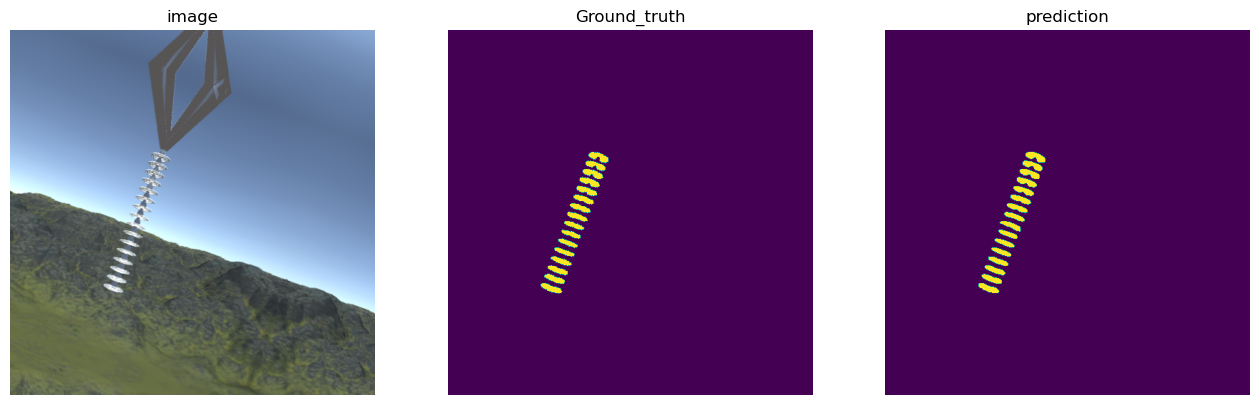

In [37]:
indx = np.random.randint(0, 2)
test_prediction = torch.argmax(y_hat[indx], 0).to('cpu').numpy()
Ground_truth = torch.argmax(y[indx], 0).to('cpu').numpy()
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(16,9))
ax1.imshow(x[indx].to('cpu').numpy().transpose(1,2,0))
ax1.set_title('image')
ax1.axis('off')
ax2.imshow(Ground_truth)
ax2.set_title('Ground_truth')
ax2.axis('off')
ax3.imshow(test_prediction)
ax3.set_title("prediction")
ax3.axis('off')


In [38]:

torch.save(model.state_dict(), f'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_glass.pth')

In [39]:
#load model 
model_path =r'C:/Users/User/Desktop/rakin2/segment/artifacts/model_ckpt/unet_resnet50_glass.pth'
model = model_selection(model_config['model_name'], model_config['backbone'],model_config['weights'])
model.load_state_dict(torch.load(model_path))

C:\Users\User\AppData\Local\Temp\ipykernel_20164\1793991064.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


<All keys matched successfully>

In [40]:
model.to('cuda')

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [41]:
dir = 'C:/Users/User/Desktop/rakin2/segment/notebook/real_dataset.csv'

In [42]:
transform = A.Compose([
    A.Resize(transform_config['image_size'], transform_config['image_size']),
    # A.RGBShift(r_shift_limit=transform_config['r_shift_limit'], g_shift_limit=transform_config['g_shift_limit'], b_shift_limit=transform_config['b_shift_limit'], p=transform_config['RGB_Shift_p']),
    # A.RandomBrightnessContrast(brightness_limit=transform_config['brightness_limit'], contrast_limit=transform_config['contrast_limit'], p=transform_config['RandomBrightnessContrast_p']),
    # A.ShiftScaleRotate(shift_limit=transform_config['shift_limit'], scale_limit=transform_config['scale_limit'], rotate_limit=transform_config['rotate_limit'], p=transform_config['ShiftScaleRotate_p'])
], is_check_shapes=False)

In [43]:
real_data = SegmentDataset(dir,2,transform=transform )

In [44]:
real_dataloader = torch.utils.data.DataLoader(real_data, batch_size=10, shuffle=True)

In [45]:
#images, masks = next(iter(real_dataloader))

In [46]:
print(f'sahpe of the image {images.shape} and mask {masks.shape} ,images type {type(images)} and mask type {type(masks)}')

sahpe of the image torch.Size([2, 3, 512, 512]) and mask torch.Size([2, 2, 512, 512]) ,images type <class 'torch.Tensor'> and mask type <class 'torch.Tensor'>


In [47]:
#model.eval()
#real_predictions = []

#with torch.no_grad():
    #for images, masks in tqdm(real_dataloader):
        #images = images.to('cuda')
        #masks = masks.to('cuda')
        #outputs = model(images)
        #preds = torch.argmax(outputs, dim=1)
        #0+.
#real_predictions.append(preds.cpu().numpy())


In [48]:
plt.figure(figsize=(16, 16))

<Figure size 1600x1600 with 0 Axes>

<Figure size 1600x1600 with 0 Axes>

In [49]:
# import matplotlib.pyplot as plt
# random_indx = np.random.randint(0, 1000)
# Select a random index to visualize
# indx = np.random.randint(0, len(images))

# Get the image, ground truth, and prediction
# image = images[indx].to('cpu').numpy().transpose(1, 2, 0)
# ground_truth = torch.argmax(masks[indx], 0).to('cpu').numpy()
# prediction = torch.argmax(outputs[indx], 0).to('cpu').numpy()

# Plot the image, ground truth, and prediction
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# ax1.imshow(image)
# ax1.set_title('Image')
# ax1.axis('off')
# ax2.imshow(prediction)
# ax2.set_title('Ground Truth')
# ax2.axis('off')
# plt.savefig(f'prediction{random_indx}.png')
# plt.show()